# 02 — Data Cleaning & Exploratory Data Analysis
## The Ship Index: Can shipping costs predict GDP?

In this notebook we:
1. Load our raw data from Phase 1
2. Aggregate daily BDI to quarterly frequency
3. Calculate growth rates for both BDI and GDP
4. Merge into a single analysis-ready DataFrame
5. Create exploratory visualisations — including the **hero dual-axis chart**
6. Annotate major economic events

By the end, we'll have a clear visual sense of whether the BDI and GDP move together.

---
## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

# Colour palette — navy theme to match shipping
NAVY = '#0C2340'
BLUE = '#1A5276'
LIGHT_BLUE = '#2E86C1'
RED = '#C0392B'
GREEN = '#1E8449'
GREY = '#7F8C8D'

print('All libraries loaded successfully!')

All libraries loaded successfully!


---
## 1. Load Raw Data

In [2]:
# Load GDP data
gdp_df = pd.read_csv('../data/raw/gdp_quarterly.csv', index_col='date', parse_dates=True)
print(f'✓ GDP data loaded: {gdp_df.shape[0]} rows, {gdp_df.shape[1]} columns')
print(f'  Period: {gdp_df.index[0].strftime("%Y-%m-%d")} to {gdp_df.index[-1].strftime("%Y-%m-%d")}')

# Load BDI data
bdi_df = pd.read_csv('../data/raw/bdi_daily.csv', index_col='date', parse_dates=True)
print(f'\n✓ BDI data loaded: {bdi_df.shape[0]} rows')
print(f'  Period: {bdi_df.index[0].strftime("%Y-%m-%d")} to {bdi_df.index[-1].strftime("%Y-%m-%d")}')

✓ GDP data loaded: 104 rows, 3 columns
  Period: 2000-01-01 to 2025-10-01

✓ BDI data loaded: 5000 rows
  Period: 2000-01-04 to 2020-01-06


---
## 2. Aggregate BDI to Quarterly

The BDI is daily but GDP is quarterly. We need to align them.

We'll create **three** quarterly BDI measures to see which works best:
- **Mean**: average BDI over the quarter (smooths out noise)
- **End-of-quarter**: last available value (point-in-time snapshot)
- **Max**: peak BDI in the quarter (captures demand surges)

In [4]:
# Resample daily BDI to quarterly using multiple aggregation methods
bdi_quarterly = pd.DataFrame({
    'bdi_mean': bdi_df['bdi_close'].resample('QS').mean(),     # Quarter Start frequency
    'bdi_end': bdi_df['bdi_close'].resample('QS').last(),      # Last value in quarter
    'bdi_max': bdi_df['bdi_close'].resample('QS').max(),       # Peak value in quarter
    'bdi_min': bdi_df['bdi_close'].resample('QS').min(),       # Lowest value in quarter
    'bdi_volatility': bdi_df['bdi_close'].resample('QS').std() # Volatility within quarter
})

print(f'✓ BDI aggregated to quarterly: {len(bdi_quarterly)} quarters')
print(f'  Period: {bdi_quarterly.index[0].strftime("%Y-%m")} to {bdi_quarterly.index[-1].strftime("%Y-%m")}')
print(f'\nFirst few rows:')
bdi_quarterly.head()

✓ BDI aggregated to quarterly: 81 quarters
  Period: 2000-01 to 2020-01

First few rows:


,bdi_mean,bdi_end,bdi_max,bdi_min,bdi_volatility
date,,,,,
2000-01-01,1467.796875,1660.0,1660.0,1276.0,129.487657
2000-04-01,1615.559322,1616.0,1686.0,1559.0,39.292568
2000-07-01,1656.206349,1739.0,1740.0,1600.0,43.903545
2000-10-01,1692.444444,1599.0,1762.0,1581.0,60.536786
2001-01-01,1516.703125,1438.0,1599.0,1438.0,46.082975


---
## 3. Calculate Growth Rates

Raw GDP and BDI values aren't comparable — one is in billions of pounds, the other is an index.

We convert both to **quarter-on-quarter percentage change** so we're comparing like with like:
- *"GDP grew 0.5% this quarter"* vs *"BDI rose 15% this quarter"*

This is the transformation that makes our analysis possible.

In [5]:
# GDP quarter-on-quarter growth rates (%)
gdp_growth = pd.DataFrame({
    'uk_gdp_growth': gdp_df['uk_gdp'].pct_change() * 100,
    'us_gdp_growth': gdp_df['us_gdp'].pct_change() * 100,
    'eurozone_gdp_growth': gdp_df['eurozone_gdp'].pct_change() * 100
})

# BDI quarter-on-quarter growth rates (%)
bdi_growth = pd.DataFrame({
    'bdi_mean_growth': bdi_quarterly['bdi_mean'].pct_change() * 100,
    'bdi_end_growth': bdi_quarterly['bdi_end'].pct_change() * 100
})

print('✓ Growth rates calculated')
print(f'\nGDP growth summary (UK):')
print(f'  Mean quarterly growth: {gdp_growth["uk_gdp_growth"].mean():.2f}%')
print(f'  Worst quarter: {gdp_growth["uk_gdp_growth"].min():.2f}%')
print(f'  Best quarter: {gdp_growth["uk_gdp_growth"].max():.2f}%')
print(f'\nBDI growth summary:')
print(f'  Mean quarterly change: {bdi_growth["bdi_mean_growth"].mean():.2f}%')
print(f'  Worst quarter: {bdi_growth["bdi_mean_growth"].min():.2f}%')
print(f'  Best quarter: {bdi_growth["bdi_mean_growth"].max():.2f}%')
print(f'\nNotice how much more volatile the BDI is compared to GDP — that\'s expected!')

✓ Growth rates calculated

GDP growth summary (UK):
  Mean quarterly growth: 0.41%
  Worst quarter: -19.91%
  Best quarter: 16.96%

BDI growth summary:
  Mean quarterly change: 5.05%
  Worst quarter: -83.59%
  Best quarter: 104.03%

Notice how much more volatile the BDI is compared to GDP — that's expected!


---
## 4. Merge Into Analysis-Ready DataFrame

Now we combine everything into a single DataFrame aligned by quarter.

In [6]:
# Merge all quarterly data
analysis_df = pd.concat([
    gdp_df,           # Raw GDP values
    gdp_growth,       # GDP growth rates
    bdi_quarterly,    # BDI quarterly aggregates
    bdi_growth        # BDI growth rates
], axis=1)

# Drop rows where we don't have both BDI and GDP data
analysis_df = analysis_df.dropna(subset=['uk_gdp', 'bdi_mean'])

print(f'✓ Analysis DataFrame created')
print(f'  Shape: {analysis_df.shape}')
print(f'  Period: {analysis_df.index[0].strftime("%Y-%m-%d")} to {analysis_df.index[-1].strftime("%Y-%m-%d")}')
print(f'  Quarters with complete data: {len(analysis_df)}')
print(f'\nColumns:')
for col in analysis_df.columns:
    non_null = analysis_df[col].notna().sum()
    print(f'  {col}: {non_null} values')

✓ Analysis DataFrame created
  Shape: (81, 13)
  Period: 2000-01-01 to 2020-01-01
  Quarters with complete data: 81

Columns:
  uk_gdp: 81 values
  us_gdp: 81 values
  eurozone_gdp: 81 values
  uk_gdp_growth: 80 values
  us_gdp_growth: 80 values
  eurozone_gdp_growth: 80 values
  bdi_mean: 81 values
  bdi_end: 81 values
  bdi_max: 81 values
  bdi_min: 81 values
  bdi_volatility: 81 values
  bdi_mean_growth: 80 values
  bdi_end_growth: 80 values


In [7]:
# Save the processed data
import os
os.makedirs('../data/processed', exist_ok=True)
analysis_df.to_csv('../data/processed/analysis_quarterly.csv')
print('✓ Saved to data/processed/analysis_quarterly.csv')

✓ Saved to data/processed/analysis_quarterly.csv


---
## 5. Exploratory Visualisations

Now the fun part — let's see what the data looks like.

### 5.1 The Hero Chart: BDI vs UK GDP Growth (Dual Axis)

This is the most important chart in the project. If the BDI is a leading indicator,
we should see BDI movements **precede** GDP movements.

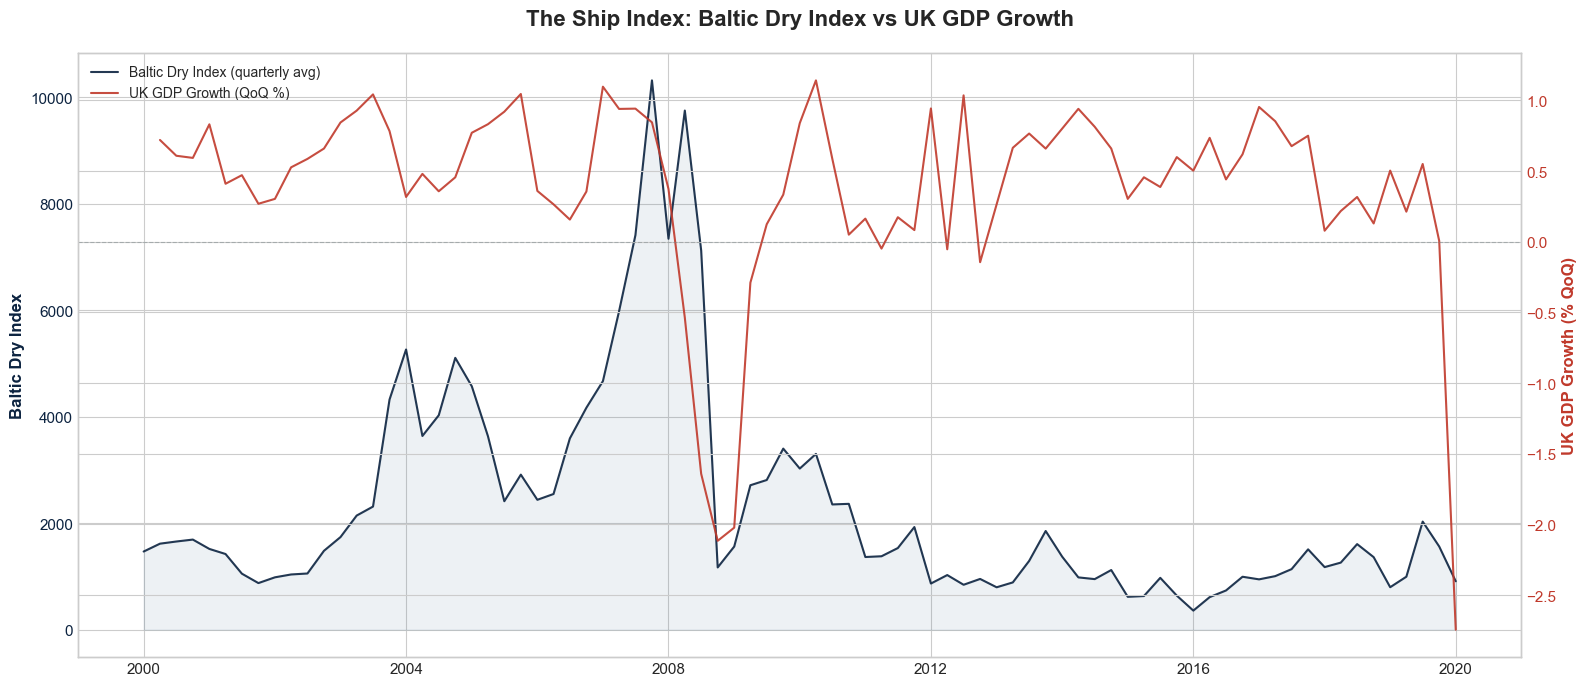


👆 This is the hero chart. Look for moments where the BDI moves BEFORE GDP.
If the blue line leads the red line at turning points, we have a signal.


In [8]:
fig, ax1 = plt.subplots(figsize=(16, 7))

# BDI on left axis
ax1.plot(analysis_df.index, analysis_df['bdi_mean'], color=NAVY, linewidth=1.5, label='Baltic Dry Index (quarterly avg)', alpha=0.9)
ax1.fill_between(analysis_df.index, analysis_df['bdi_mean'], alpha=0.08, color=BLUE)
ax1.set_ylabel('Baltic Dry Index', color=NAVY, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=NAVY)

# GDP growth on right axis
ax2 = ax1.twinx()
ax2.plot(analysis_df.index, analysis_df['uk_gdp_growth'], color=RED, linewidth=1.5, label='UK GDP Growth (QoQ %)', alpha=0.9)
ax2.axhline(y=0, color=GREY, linewidth=0.8, linestyle='--', alpha=0.5)
ax2.set_ylabel('UK GDP Growth (% QoQ)', color=RED, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=RED)

# Title
ax1.set_title('The Ship Index: Baltic Dry Index vs UK GDP Growth', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.savefig('../outputs/hero_chart_bdi_vs_uk_gdp.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n👆 This is the hero chart. Look for moments where the BDI moves BEFORE GDP.')
print('If the blue line leads the red line at turning points, we have a signal.')

### 5.2 Annotated Timeline: Key Economic Events

Let's overlay major events to see how the BDI reacted vs GDP.

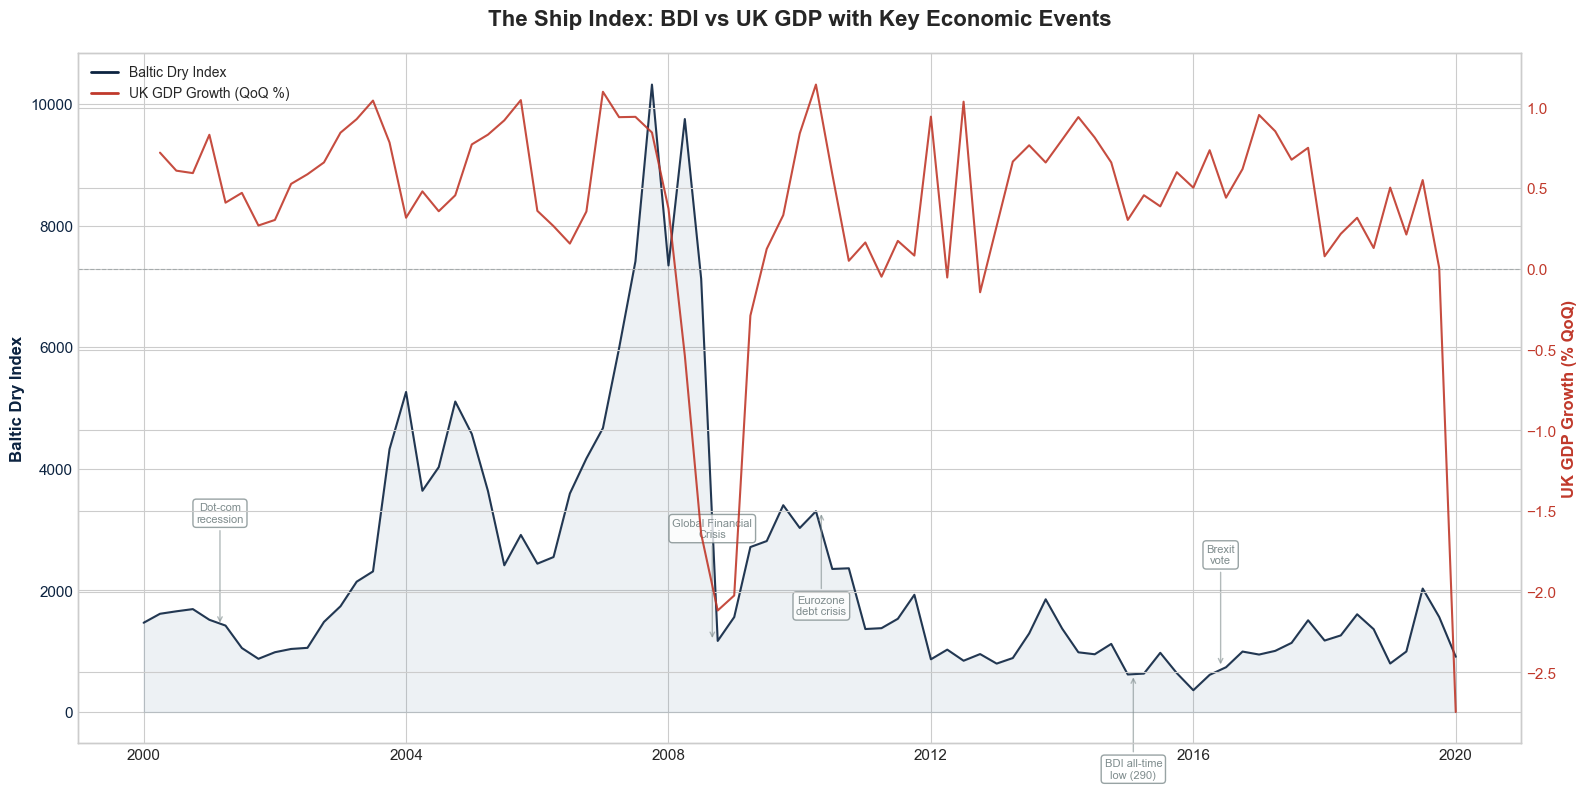


👆 Look at the 2008 GFC — did the BDI crash before GDP fell?
And COVID — how did the BDI react vs the GDP drop?


In [9]:
# Define key economic events
events = [
    ('2001-03-01', 'Dot-com\nrecession', 'top'),
    ('2008-09-01', 'Global Financial\nCrisis', 'top'),
    ('2010-05-01', 'Eurozone\ndebt crisis', 'bottom'),
    ('2015-02-01', 'BDI all-time\nlow (290)', 'bottom'),
    ('2016-06-01', 'Brexit\nvote', 'top'),
    ('2020-03-01', 'COVID-19\ncrash', 'top'),
    ('2021-10-01', 'Supply chain\ncrisis', 'top'),
    ('2022-03-01', 'Ukraine war\nenergy shock', 'bottom'),
]

fig, ax1 = plt.subplots(figsize=(16, 8))

# BDI
ax1.plot(analysis_df.index, analysis_df['bdi_mean'], color=NAVY, linewidth=1.5, alpha=0.9)
ax1.fill_between(analysis_df.index, analysis_df['bdi_mean'], alpha=0.08, color=BLUE)
ax1.set_ylabel('Baltic Dry Index', color=NAVY, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=NAVY)

# GDP growth
ax2 = ax1.twinx()
ax2.plot(analysis_df.index, analysis_df['uk_gdp_growth'], color=RED, linewidth=1.5, alpha=0.9)
ax2.axhline(y=0, color=GREY, linewidth=0.8, linestyle='--', alpha=0.5)
ax2.set_ylabel('UK GDP Growth (% QoQ)', color=RED, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=RED)

# Add event annotations
for date_str, label, position in events:
    date = pd.Timestamp(date_str)
    if date >= analysis_df.index[0] and date <= analysis_df.index[-1]:
        # Get BDI value at this point for arrow positioning
        nearest_idx = analysis_df.index.get_indexer([date], method='nearest')[0]
        bdi_val = analysis_df['bdi_mean'].iloc[nearest_idx]
        
        if position == 'top':
            ax1.annotate(label, xy=(date, bdi_val),
                        xytext=(date, bdi_val + (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.15),
                        fontsize=8, ha='center', color=GREY,
                        arrowprops=dict(arrowstyle='->', color=GREY, alpha=0.6),
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=GREY, alpha=0.8))
        else:
            ax1.annotate(label, xy=(date, bdi_val),
                        xytext=(date, bdi_val - (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.15),
                        fontsize=8, ha='center', color=GREY,
                        arrowprops=dict(arrowstyle='->', color=GREY, alpha=0.6),
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=GREY, alpha=0.8))

ax1.set_title('The Ship Index: BDI vs UK GDP with Key Economic Events', fontsize=16, fontweight='bold', pad=20)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=NAVY, linewidth=2, label='Baltic Dry Index'),
    Line2D([0], [0], color=RED, linewidth=2, label='UK GDP Growth (QoQ %)')
]
ax1.legend(handles=legend_elements, loc='upper left', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.savefig('../outputs/annotated_timeline.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n👆 Look at the 2008 GFC — did the BDI crash before GDP fell?')
print('And COVID — how did the BDI react vs the GDP drop?')

### 5.3 Growth Rate Comparison: BDI vs GDP Changes

Now let's compare the **growth rates** directly — this is what we'll actually use for correlation analysis.

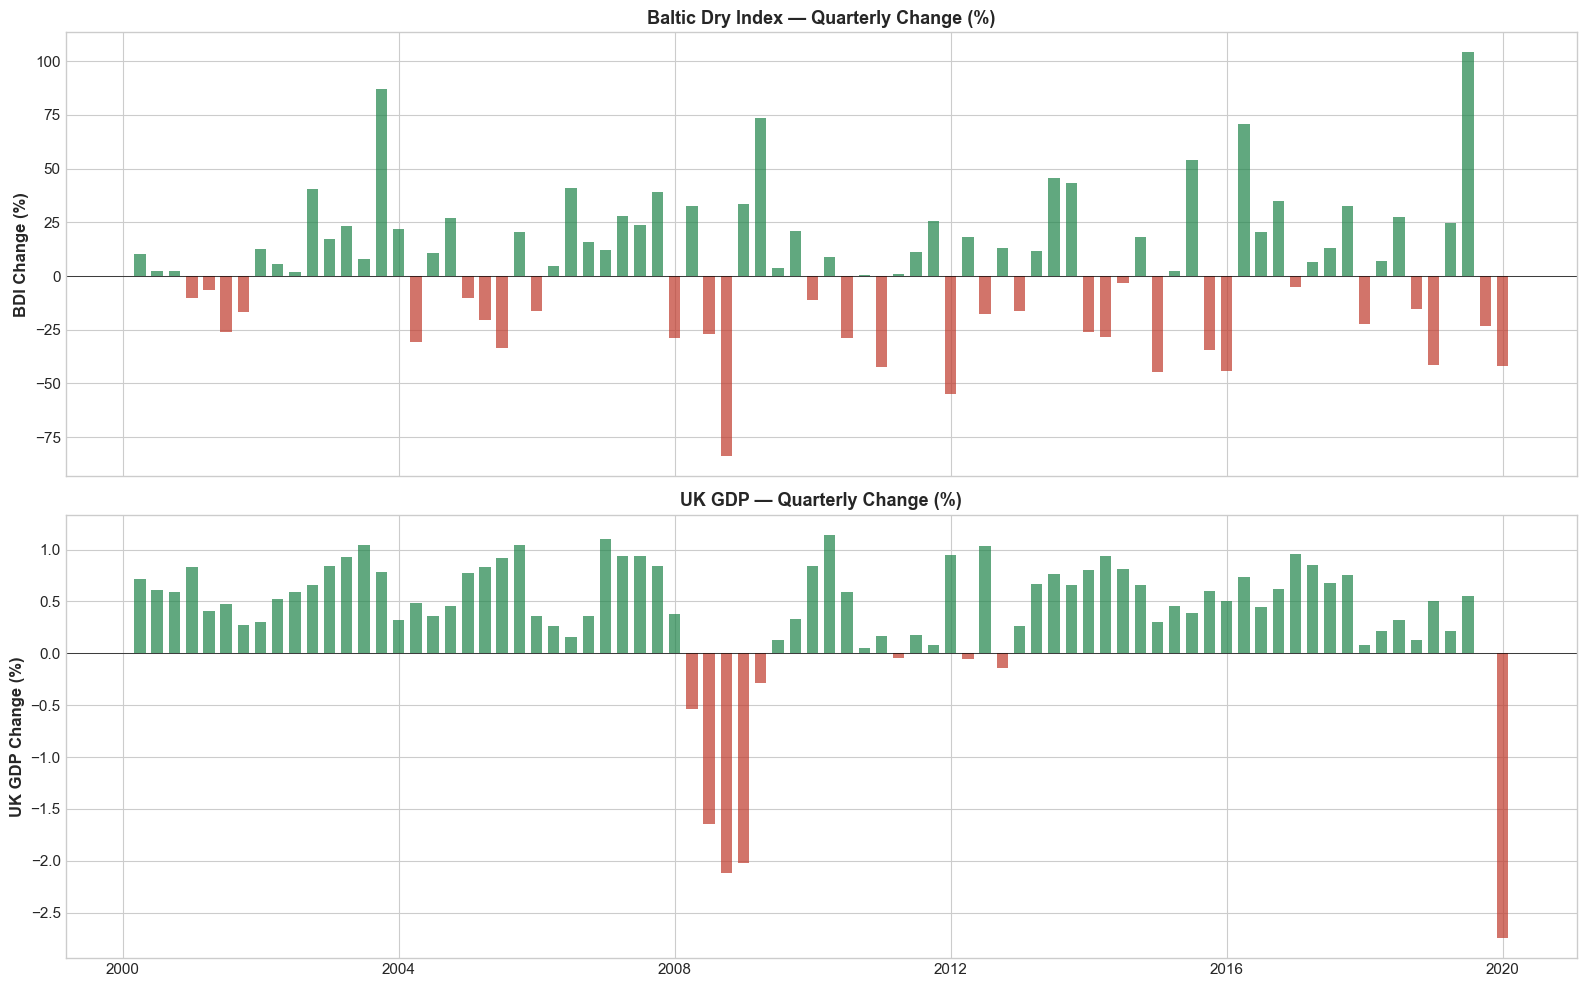


👆 Compare the red bars (contractions) — do BDI contractions appear BEFORE GDP contractions?


In [10]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# BDI growth
axes[0].bar(analysis_df.index, analysis_df['bdi_mean_growth'],
           width=60, color=[GREEN if x >= 0 else RED for x in analysis_df['bdi_mean_growth'].fillna(0)],
           alpha=0.7)
axes[0].axhline(y=0, color='black', linewidth=0.5)
axes[0].set_ylabel('BDI Change (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Baltic Dry Index — Quarterly Change (%)', fontsize=13, fontweight='bold')

# GDP growth
axes[1].bar(analysis_df.index, analysis_df['uk_gdp_growth'],
           width=60, color=[GREEN if x >= 0 else RED for x in analysis_df['uk_gdp_growth'].fillna(0)],
           alpha=0.7)
axes[1].axhline(y=0, color='black', linewidth=0.5)
axes[1].set_ylabel('UK GDP Change (%)', fontsize=12, fontweight='bold')
axes[1].set_title('UK GDP — Quarterly Change (%)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/growth_rate_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n👆 Compare the red bars (contractions) — do BDI contractions appear BEFORE GDP contractions?')

### 5.4 Scatter Plot: BDI Change vs GDP Change

A scatter plot gives us a first look at whether there's a linear relationship.

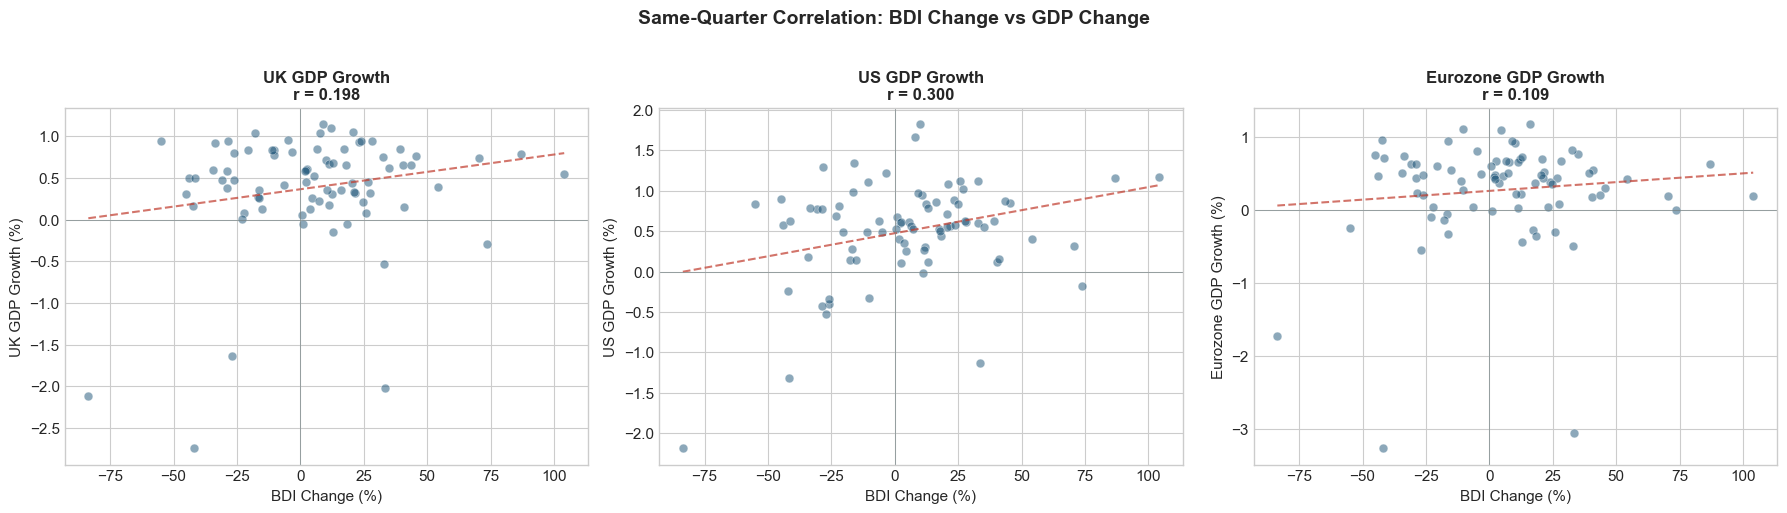


👆 The r value shows the same-quarter correlation.
But remember — we're looking for a LEADING relationship.
The BDI from THIS quarter might predict GDP NEXT quarter.
We'll test lagged correlations in Phase 3.


In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

economies = [
    ('uk_gdp_growth', 'UK GDP Growth'),
    ('us_gdp_growth', 'US GDP Growth'),
    ('eurozone_gdp_growth', 'Eurozone GDP Growth')
]

for ax, (col, title) in zip(axes, economies):
    # Drop NaN rows for this pair
    mask = analysis_df[['bdi_mean_growth', col]].dropna()
    
    ax.scatter(mask['bdi_mean_growth'], mask[col], color=BLUE, alpha=0.5, s=40, edgecolors='white', linewidth=0.5)
    
    # Add trend line
    z = np.polyfit(mask['bdi_mean_growth'], mask[col], 1)
    p = np.poly1d(z)
    x_line = np.linspace(mask['bdi_mean_growth'].min(), mask['bdi_mean_growth'].max(), 100)
    ax.plot(x_line, p(x_line), color=RED, linewidth=1.5, linestyle='--', alpha=0.7)
    
    # Correlation
    corr = mask['bdi_mean_growth'].corr(mask[col])
    ax.set_title(f'{title}\nr = {corr:.3f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('BDI Change (%)')
    ax.set_ylabel(f'{title} (%)')
    ax.axhline(y=0, color=GREY, linewidth=0.5, linestyle='-')
    ax.axvline(x=0, color=GREY, linewidth=0.5, linestyle='-')

plt.suptitle('Same-Quarter Correlation: BDI Change vs GDP Change', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/scatter_bdi_vs_gdp.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n👆 The r value shows the same-quarter correlation.')
print('But remember — we\'re looking for a LEADING relationship.')
print('The BDI from THIS quarter might predict GDP NEXT quarter.')
print('We\'ll test lagged correlations in Phase 3.')

### 5.5 Lagged Scatter: Does This Quarter's BDI Predict Next Quarter's GDP?

This is the **Pentagon Pizza insight** — the whole point of the project.
Let's do a quick preview by shifting the BDI back by 1 quarter.

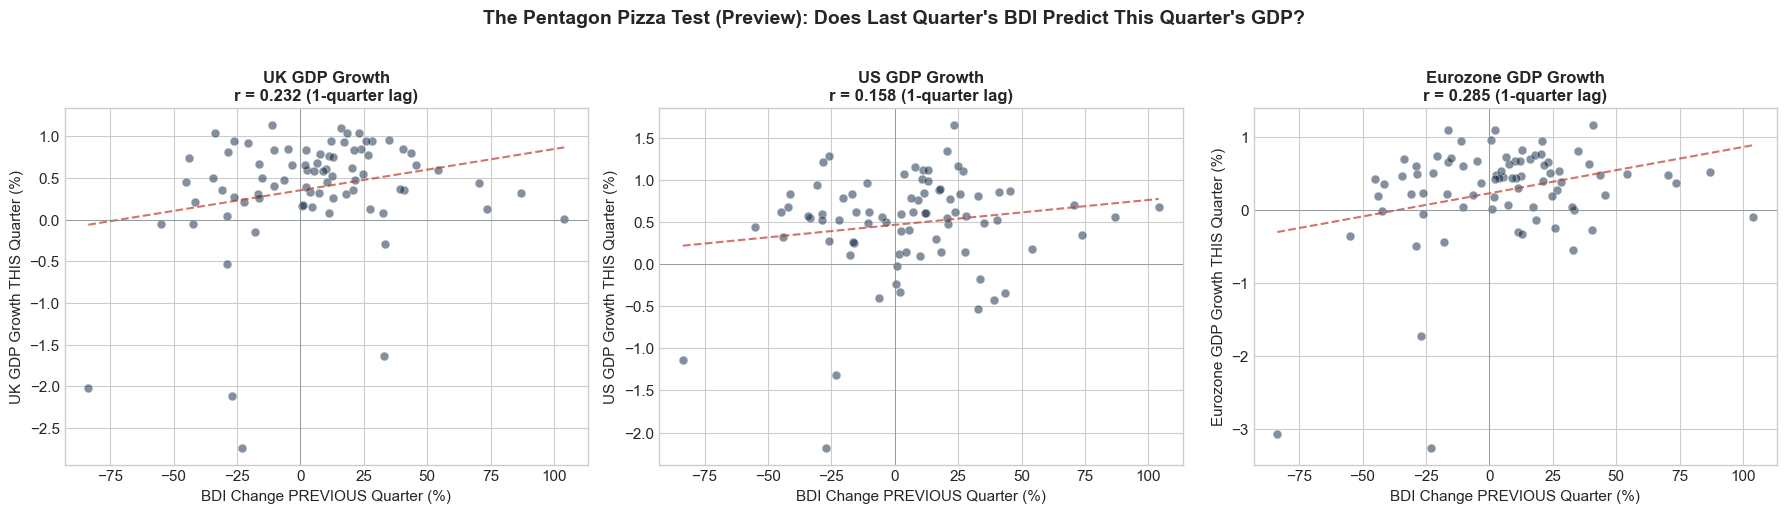


👆 Compare these r values with the same-quarter ones above.
If the lagged correlation is STRONGER, the BDI is a leading indicator!
We'll do a full lag analysis (0-4 quarters) in Phase 3.


In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (col, title) in zip(axes, economies):
    # Create lagged BDI (shift BDI growth back by 1 quarter)
    lagged = pd.DataFrame({
        'bdi_prev_quarter': analysis_df['bdi_mean_growth'].shift(1),
        'gdp_this_quarter': analysis_df[col]
    }).dropna()
    
    ax.scatter(lagged['bdi_prev_quarter'], lagged['gdp_this_quarter'],
              color=NAVY, alpha=0.5, s=40, edgecolors='white', linewidth=0.5)
    
    # Trend line
    z = np.polyfit(lagged['bdi_prev_quarter'], lagged['gdp_this_quarter'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(lagged['bdi_prev_quarter'].min(), lagged['bdi_prev_quarter'].max(), 100)
    ax.plot(x_line, p(x_line), color=RED, linewidth=1.5, linestyle='--', alpha=0.7)
    
    # Correlation
    corr = lagged['bdi_prev_quarter'].corr(lagged['gdp_this_quarter'])
    ax.set_title(f'{title}\nr = {corr:.3f} (1-quarter lag)', fontsize=12, fontweight='bold')
    ax.set_xlabel('BDI Change PREVIOUS Quarter (%)')
    ax.set_ylabel(f'{title} THIS Quarter (%)')
    ax.axhline(y=0, color=GREY, linewidth=0.5, linestyle='-')
    ax.axvline(x=0, color=GREY, linewidth=0.5, linestyle='-')

plt.suptitle('The Pentagon Pizza Test (Preview): Does Last Quarter\'s BDI Predict This Quarter\'s GDP?',
            fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/lagged_scatter_preview.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n👆 Compare these r values with the same-quarter ones above.')
print('If the lagged correlation is STRONGER, the BDI is a leading indicator!')
print('We\'ll do a full lag analysis (0-4 quarters) in Phase 3.')

### 5.6 BDI Distribution: What Does the BDI Look Like Before Recessions?

Let's split the data into quarters where GDP grew vs contracted,
and see how the BDI behaved in the **preceding** quarter.

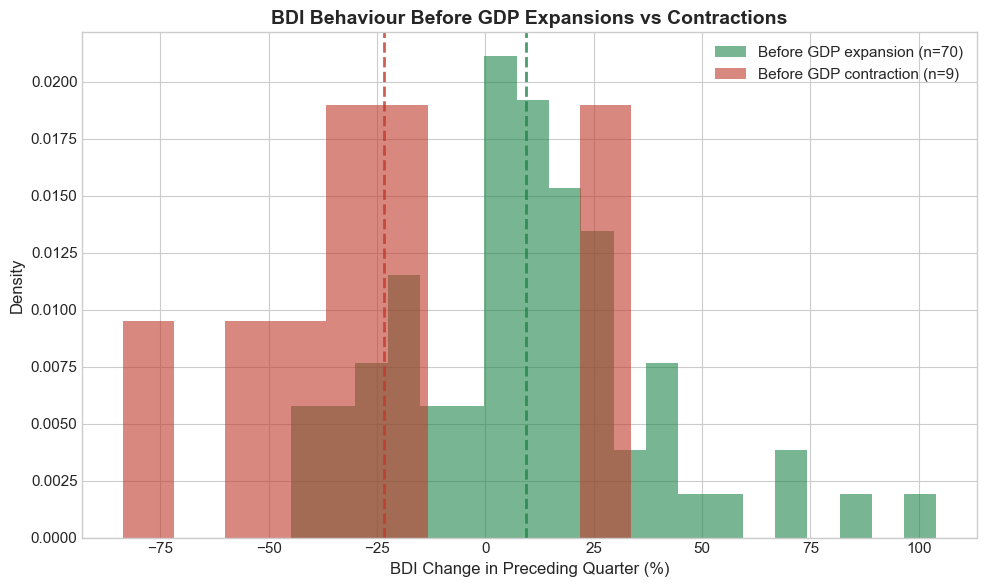


Average BDI change before GDP expansion:  +9.4%
Average BDI change before GDP contraction: -23.5%

If the red distribution sits to the LEFT of the green, the BDI drops before recessions.


In [13]:
# Create a simple recession indicator (negative GDP growth)
analysis_df['uk_contraction'] = analysis_df['uk_gdp_growth'] < 0

# BDI growth in the quarter BEFORE a contraction vs before an expansion
bdi_before_contraction = analysis_df.loc[analysis_df['uk_contraction'].shift(-1) == True, 'bdi_mean_growth'].dropna()
bdi_before_expansion = analysis_df.loc[analysis_df['uk_contraction'].shift(-1) == False, 'bdi_mean_growth'].dropna()

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(bdi_before_expansion, bins=20, alpha=0.6, color=GREEN, label=f'Before GDP expansion (n={len(bdi_before_expansion)})', density=True)
ax.hist(bdi_before_contraction, bins=10, alpha=0.6, color=RED, label=f'Before GDP contraction (n={len(bdi_before_contraction)})', density=True)

ax.axvline(bdi_before_expansion.mean(), color=GREEN, linestyle='--', linewidth=2, alpha=0.8)
ax.axvline(bdi_before_contraction.mean(), color=RED, linestyle='--', linewidth=2, alpha=0.8)

ax.set_xlabel('BDI Change in Preceding Quarter (%)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('BDI Behaviour Before GDP Expansions vs Contractions', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('../outputs/bdi_before_contraction.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nAverage BDI change before GDP expansion:  {bdi_before_expansion.mean():+.1f}%')
print(f'Average BDI change before GDP contraction: {bdi_before_contraction.mean():+.1f}%')
print(f'\nIf the red distribution sits to the LEFT of the green, the BDI drops before recessions.')

---
## 6. Multi-Economy Comparison

Does the BDI predict trade-dependent economies better?

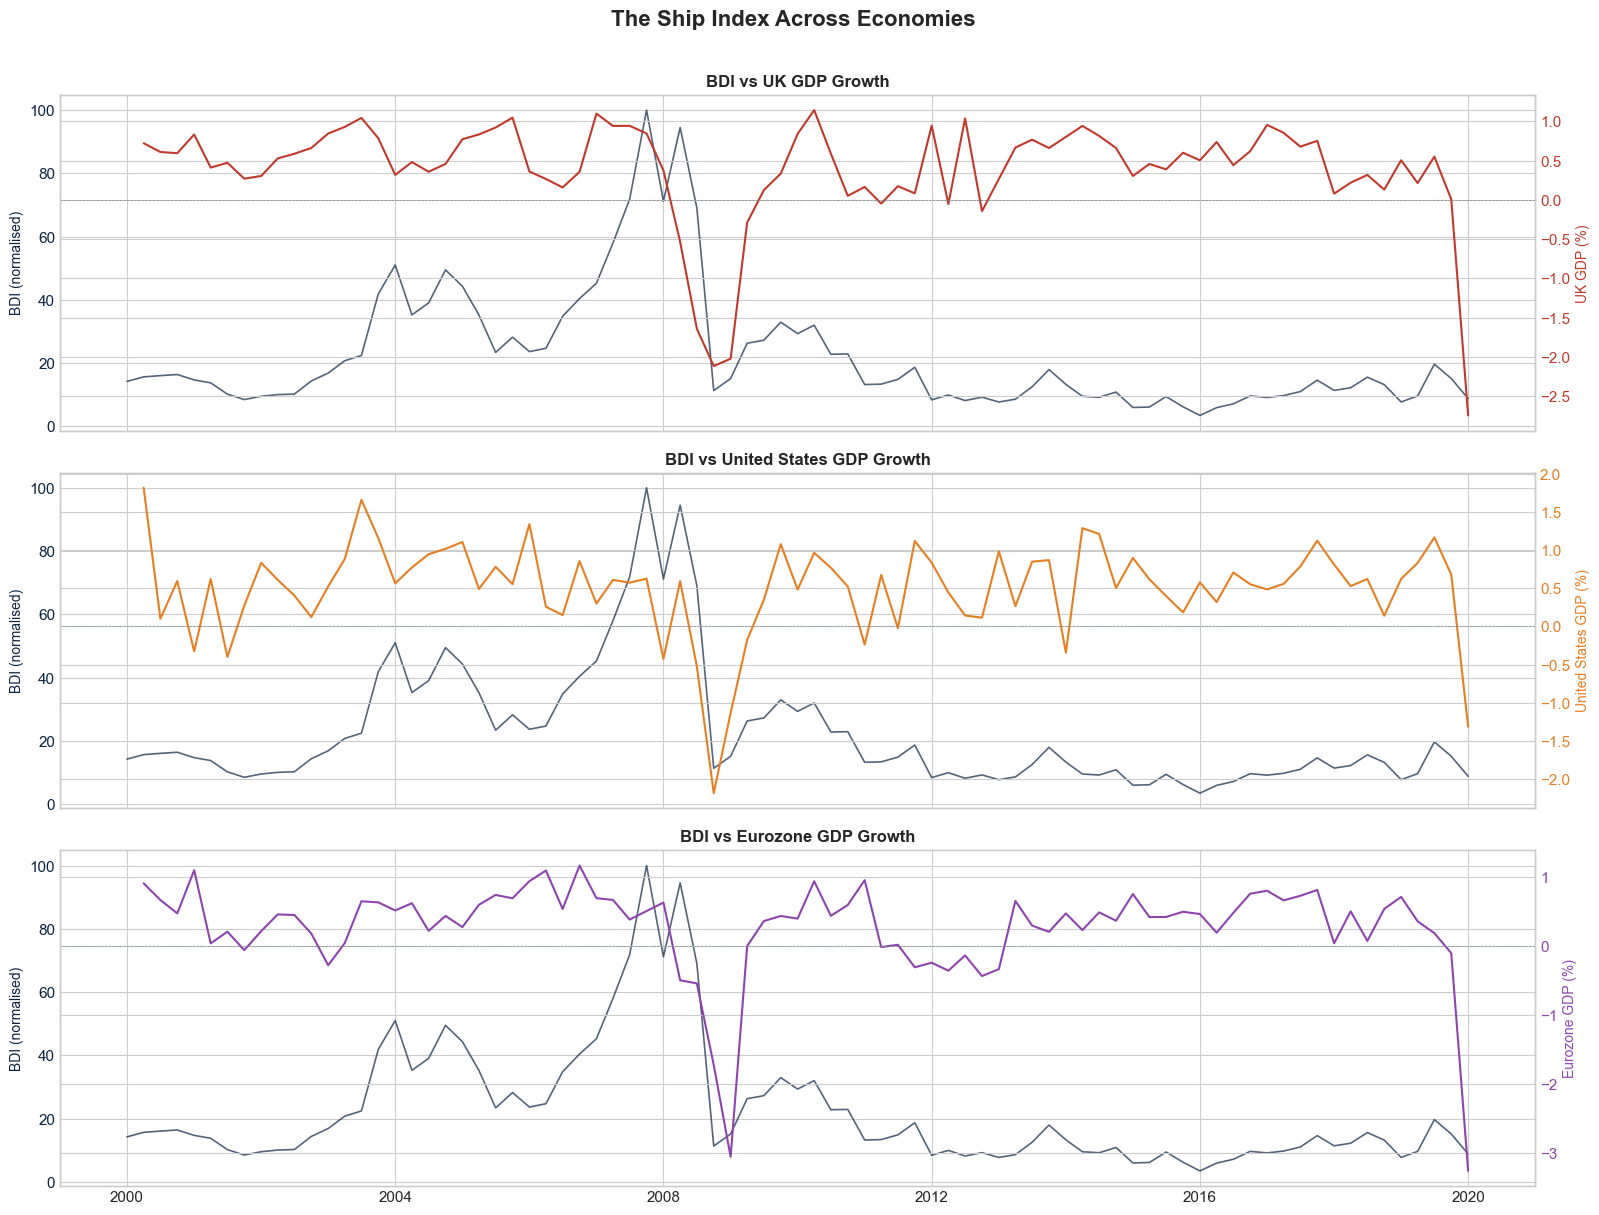


👆 Compare how closely the BDI tracks each economy.
Trade-dependent economies (UK, Eurozone) may show stronger relationships.


In [14]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

economy_configs = [
    ('uk_gdp_growth', 'UK', '#C0392B'),
    ('us_gdp_growth', 'United States', '#E67E22'),
    ('eurozone_gdp_growth', 'Eurozone', '#8E44AD')
]

for ax, (col, name, color) in zip(axes, economy_configs):
    ax.plot(analysis_df.index, analysis_df['bdi_mean'] / analysis_df['bdi_mean'].max() * 100,
           color=NAVY, linewidth=1.2, alpha=0.7, label='BDI (normalised)')
    
    ax_twin = ax.twinx()
    ax_twin.plot(analysis_df.index, analysis_df[col], color=color, linewidth=1.5, label=f'{name} GDP Growth')
    ax_twin.axhline(y=0, color=GREY, linewidth=0.5, linestyle='--')
    ax_twin.set_ylabel(f'{name} GDP (%)', color=color, fontsize=10)
    ax_twin.tick_params(axis='y', labelcolor=color)
    
    ax.set_ylabel('BDI (normalised)', color=NAVY, fontsize=10)
    ax.tick_params(axis='y', labelcolor=NAVY)
    ax.set_title(f'BDI vs {name} GDP Growth', fontsize=12, fontweight='bold')

plt.suptitle('The Ship Index Across Economies', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('../outputs/multi_economy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n👆 Compare how closely the BDI tracks each economy.')
print('Trade-dependent economies (UK, Eurozone) may show stronger relationships.')

---
## 7. Initial Observations

Write down what you see in the charts — these become the hypotheses we test in Phase 3.

**Questions to consider:**
- Does the BDI appear to move before GDP at major turning points?
- Is the relationship stronger for some economies than others?
- Are there periods where the BDI gives a false signal?
- How does COVID distort the picture?

In [15]:
# Summary statistics for the analysis dataset
print('='*60)
print('PHASE 2 SUMMARY')
print('='*60)
print(f'\nAnalysis period: {analysis_df.index[0].strftime("%B %Y")} to {analysis_df.index[-1].strftime("%B %Y")}')
print(f'Total quarters: {len(analysis_df)}')
print(f'\nCharts saved to outputs/:')
import glob
for f in sorted(glob.glob('../outputs/*.png')):
    print(f'  ✓ {f.split("/")[-1]}')
print(f'\nProcessed data saved to: data/processed/analysis_quarterly.csv')
print(f'\n--- Ready for Phase 3: Statistical Analysis ---')

PHASE 2 SUMMARY

Analysis period: January 2000 to January 2020
Total quarters: 81

Charts saved to outputs/:
  ✓ outputs\annotated_timeline.png
  ✓ outputs\bdi_before_contraction.png
  ✓ outputs\growth_rate_comparison.png
  ✓ outputs\hero_chart_bdi_vs_uk_gdp.png
  ✓ outputs\lagged_scatter_preview.png
  ✓ outputs\multi_economy_comparison.png
  ✓ outputs\scatter_bdi_vs_gdp.png

Processed data saved to: data/processed/analysis_quarterly.csv

--- Ready for Phase 3: Statistical Analysis ---


---
## ✅ Phase 2 Complete!

**What we've accomplished:**
- Aggregated daily BDI to quarterly (mean, end, max, min, volatility)
- Calculated growth rates for BDI and GDP
- Created 6 publication-quality visualisations
- First look at the BDI-GDP relationship across 3 economies
- Saved analysis-ready dataset

**Key charts:**
1. Hero dual-axis chart (BDI vs UK GDP)
2. Annotated timeline with economic events
3. Growth rate bar comparison
4. Same-quarter scatter plots with correlation
5. Lagged scatter (Pentagon Pizza preview)
6. Multi-economy comparison

**Next up — Phase 3: Statistical Analysis**
- Full cross-correlation at 0–4 quarter lags
- Granger causality tests
- Regression modelling
- The Pentagon Pizza Test

Don't forget to commit!
```
git add .
git commit -m "Phase 2: Data cleaning and EDA complete — 6 visualisations created"
git push
```